In [1]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None 

import numpy as np
import math
import datetime as dt
from datetime import timedelta

# charting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")


import warnings
warnings.filterwarnings('ignore')

## Make sure the breakout is running the correct file. 

In [2]:
#################
# Definitions
#################
# Where to read data from
s3_bucket    = 'mfx-sagemaker-dev'

s3_signal_data_key = "demo/XAUUSD_20200906-000000_20200918-000000/2020-09-06T22:00:00.183Z-2020-09-18T00:00:00.991Z-Input_CFH-MORGANSTANLEY-JPM-CITADEL-JUMP-STATESTREET-FASTMATCH-HOTSPOT-LMAX-JEFFERIES-XTX-GOLDMAN_SACHS_top5-1.csv.gz"

# %% Set the file names
filename_futures_quotes = "/Volumes/GoogleDrive/Shared drives/data/go_xauusd_20200804_quotes.csv"
filename_futures_trades = "/Volumes/GoogleDrive/Shared drives/data/think_xauusd_20200804_trades_clients.csv"

# make date the same day as the market data 
date_filter = '2020-08-04'

# Bar size
resample_period = '10s'

# Chart settings
chart_padding_secs = 10

# Breakout settings
breakout_sigma = 1.0

# MR settings
mr_sigma = 10

# Hedging level
hedge_level = 3

# Hedger interest to fill time in ms
interest_to_fill = 10000

# n samples for moving average
ma_samples = 3

# optimise exits
optimise_exit = True




In [3]:
#################
# Load from S3
#################



# using S3
signal_tick_data = pd.read_csv('s3://{}/{}'.format(s3_bucket, s3_signal_data_key), index_col='t', parse_dates=['t'])


# from Drive
# signal_tick_data = pd.read_csv(filename_futures_quotes, index_col='t', parse_dates=['t'])

trigger_tick_data = signal_tick_data

reval_tick_data = signal_tick_data
# Source for tick charts
chart_tick_data = reval_tick_data

signal_tick_data['spread'] = signal_tick_data['Offer0'] - signal_tick_data['Bid0']
reval_tick_data['spread'] = reval_tick_data['Offer0'] - reval_tick_data['Bid0']




In [4]:
#################
# Aggregate tick data
#################
signal_mid_price_series = (signal_tick_data.loc[:, 'Bid0'] + signal_tick_data.loc[:, 'Offer0']) / 2
trigger_mid_price_series = (trigger_tick_data.loc[:, 'Bid0'] + trigger_tick_data.loc[:, 'Offer0']) / 2
reval_mid_price_series = (reval_tick_data.loc[:, 'Bid0'] + reval_tick_data.loc[:, 'Offer0']) / 2
# print(reval_mid_price_series.tail())

# reval_mid_price_series['reference_mid'] = signal_mid_price_series.asof(reval_mid_price_series.index)
# print(signal_mid_price_series.asof(reval_mid_price_series.index), reval_mid_price_series)
bar_sampler = signal_mid_price_series.resample(resample_period)

hloc = bar_sampler.ohlc() # **FIXME** First tick in bar not last tick in previous bar?

# display(hloc)

In [5]:
#################
# Derived columns
#################

hloc['o_to_h'] = (hloc['high'] / hloc['open'] - 1)
hloc['o_to_l'] = (hloc['low'] / hloc['open'] - 1)
hloc['c_to_c'] = hloc['close'].pct_change()

hloc['o_to_h_vol'] = hloc['o_to_h'].rolling(ma_samples).std()
hloc['o_to_l_vol'] = hloc['o_to_l'].rolling(ma_samples).std()
hloc['c_to_c_vol'] = hloc['c_to_c'].rolling(ma_samples).std()






# hloc['6_hr_ma'] = hloc['close'].rolling(6).mean()
# hloc['6_hr_ma_sig'] = np.where(hloc['close'].shift(1) > hloc['6_hr_ma'].shift(1), 1, -1)

In [6]:
#################
# Trigger check
#################

def mid_trigger_price (timestamp, where): 
    index = trigger_mid_price_series[timestamp : timestamp + timestamp.freq].where(where).dropna().first_valid_index()
    if index == None :
        return None
    result = reval_mid_price_series.asof(index)
#     print(result)
    return result

def trigger_check(row, high_trigger_col, low_trigger_col, high_side):
    
    triggers = [
        ['High', mid_trigger_price(row.name, lambda price: price.gt(row[high_trigger_col])), 
                 +high_side, row[high_trigger_col]],
        ['Low', mid_trigger_price(row.name, lambda price: price.lt(row[low_trigger_col])),
                -high_side, row[low_trigger_col]]
    ]
    
    triggers = [t for t in triggers if t[1] is not None]
    
    triggers.sort(key=lambda t : t[1])
    
    if not triggers:
        return None
    
    return triggers[0]

In [7]:
#################
# Breakout signals
#################

hloc['breakout_high_trigger'] = hloc['open'] * (1 + (breakout_sigma * (hloc['o_to_h_vol'].shift(1))))
hloc['breakout_low_trigger'] = hloc['open'] * (1 - (breakout_sigma * (hloc['o_to_l_vol'].shift(1))))

hloc['breakout_triggered'] = hloc.apply(lambda row: trigger_check(row, 'breakout_high_trigger', 'breakout_low_trigger', 1), axis=1)
hloc['breakout_triggered'].isna().sum()

41204

In [8]:
#################
# Mean reversion signals
#################

hloc['6_hr_ma'] = hloc['close'].rolling(ma_samples).mean()
# hloc['6_hr_ma_sig'] = np.where(hloc['close'].shift(1) > hloc['6_hr_ma'].shift(1), 1, -1)

hloc['mr_high_trigger'] = hloc['6_hr_ma'] * (1 + (mr_sigma * (hloc['c_to_c_vol'].shift(1))))
hloc['mr_low_trigger'] = hloc['6_hr_ma'] * (1 - (mr_sigma * (hloc['c_to_c_vol'].shift(1))))

hloc['mr_triggered'] = hloc.apply(lambda row: trigger_check(row, 'mr_high_trigger', 'mr_low_trigger', -1), axis=1)


In [9]:
# position
hloc_filtered = hloc
hloc_filtered['breakout_trade'] = hloc_filtered['breakout_triggered'].map(lambda x: 0 if x is None else x[2])
hloc_filtered['breakout_trade_price'] = hloc_filtered['breakout_triggered'].map(lambda x: 0 if x is None else x[1])
hloc_filtered['breakout_contra_trade_amount'] = -1 * hloc_filtered['breakout_trade'] * hloc_filtered['breakout_trade_price']

hloc_filtered['mr_trade'] = hloc_filtered['mr_triggered'].map(lambda x: 0 if x is None else x[2])
hloc_filtered['mr_trade_price'] = hloc_filtered['mr_triggered'].map(lambda x: 0 if x is None else x[1])
hloc_filtered['mr_contra_trade_amount'] = -1 * hloc_filtered['mr_trade'] * hloc_filtered['mr_trade_price']
hloc_filtered['position'] = hloc_filtered['breakout_trade'].cumsum() + hloc_filtered['mr_trade'].cumsum()

stdev = np.std(hloc_filtered['close'].diff())

In [10]:
# hedge trades
hloc_filtered['hedge_trade'] = 0.0
hloc_filtered['hedge_price'] = 0.0
hedge_trade_sum = 0.0
hloc_filtered['hedge_contra_amount'] = 0.0
current_position = 0.0
keep_position = False
i_prev = None
n = len(hloc_filtered)
 
for i in hloc_filtered.index:
    stay_long, stay_short = False, False
    current_position = hloc_filtered.loc[i]['position'] + hedge_trade_sum
    
    if(optimise_exit) :
        if current_position > 0 and (hloc_filtered.loc[i]['close'] > (hloc_filtered.loc[i_prev]['close'] + 2.5 * stdev)):
            stay_long = True
        if current_position < 0 and (hloc_filtered.loc[i]['close'] < (hloc_filtered.loc[i_prev]['close'] - 2.5 * stdev)):
            stay_short = True
        keep_position = stay_long or stay_short
    
    if i_prev and not keep_position and (np.absolute(current_position) >= hedge_level):
        hloc_filtered.loc[i,'hedge_trade'] = -1 * current_position
        hedge_trade_sum += -1 * current_position
        # TODO: Review
        hedge_price = hloc_filtered.asof(i + pd.Timedelta(milliseconds=interest_to_fill),
                                         subset=['close'])['close']
        hloc_filtered.loc[i,'hedge_price'] = hedge_price
        hloc_filtered.loc[i,'hedge_contra_amount'] = -1 * hloc_filtered.loc[i,'hedge_trade'] * \
                                                     hloc_filtered.loc[i,'hedge_price']
    i_prev = i

In [11]:
hloc_filtered['hedge_balance'] = hloc_filtered['hedge_trade'].cumsum()
hloc_filtered['overall_position'] = hloc_filtered['breakout_trade'].cumsum() + hloc_filtered['mr_trade'].cumsum() + hloc_filtered['hedge_trade'].cumsum()
hloc_filtered['overall_contra_position'] = hloc_filtered['breakout_contra_trade_amount'].cumsum() + hloc_filtered['mr_contra_trade_amount'].cumsum() + hloc_filtered['hedge_contra_amount'].cumsum()

In [12]:
# #pnl
hloc_filtered['pnl'] = np.where(hloc_filtered['overall_position'] == 0, hloc_filtered['overall_contra_position'], hloc_filtered['overall_position'] * hloc_filtered['close'] + hloc_filtered['overall_contra_position'])

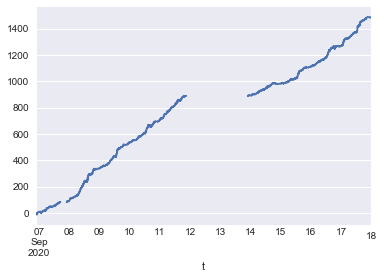

In [13]:
# plot mr strategy returns
hloc_filtered['pnl'].resample("60s").last().plot()

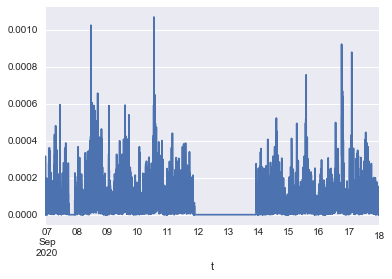

In [14]:
hloc_filtered['c_to_c_vol'].resample("1T").last().plot()

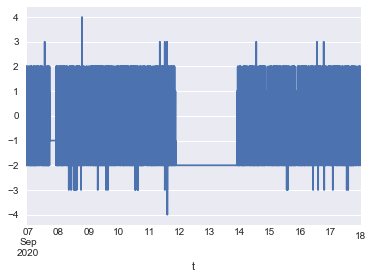

In [15]:
hloc_filtered['overall_position'].resample("1T").last().plot()

In [16]:
#volumes, pnl and yield
y = 0
breakout_volume = np.abs(hloc_filtered['breakout_trade']).sum()
mr_volume = np.abs(hloc_filtered['mr_trade']).sum()
hedge_volume = np.abs(hloc_filtered['hedge_trade']).sum()
total_volume = breakout_volume + mr_volume + hedge_volume
total_pnl = hloc_filtered['pnl'].tail(1)
y = total_pnl / total_volume 
display(breakout_volume, mr_volume, hedge_volume, total_volume, total_pnl, y)

54557

1600

16957.0

73114.0

t
2020-09-18 00:00:00+00:00    1488.34
Freq: 10S, Name: pnl, dtype: float64

t
2020-09-18 00:00:00+00:00    0.020356
Freq: 10S, Name: pnl, dtype: float64

### Order Flow Imbalance

In [17]:

# OFI lookback 
ofi_lookback = 2000
ofi_resample = "10ms"

def ofi(quotes,level):
    """Returns Order Flow Imbalance for given levels of the orderbook"""
    qdf = quotes.copy()
    bid_price_label = 'Bid' + str(level)
    offer_price_label = 'Offer' + str(level)
    bid_qty_label = 'Bid' +str(level) + 'Qty'
    offer_qty_label = 'Offer' + str(level)+'Qty'

    qdf['prev_bidprice'] = qdf[bid_price_label].shift()
    qdf['prev_bidsize'] = qdf[bid_qty_label].shift()
    qdf['prev_askprice'] = qdf[offer_price_label].shift()
    qdf['prev_asksize'] = qdf[offer_qty_label].shift()

    # Fix any missing/invalid data
    qdf.replace([np.inf, np.NINF], np.nan, inplace=True)
    qdf.fillna(method="ffill", inplace=True)
    qdf.fillna(method="bfill", inplace=True)
    
    bid_geq = qdf[bid_price_label] >= qdf['prev_bidprice']
    bid_leq = qdf[bid_price_label] <= qdf['prev_bidprice']
    ask_geq = qdf[offer_price_label] >= qdf['prev_askprice']
    ask_leq = qdf[offer_price_label] <= qdf['prev_askprice']
    
    qdf['ofi'] = np.zeros(len(qdf))
    qdf['ofi'].loc[bid_geq] += qdf[bid_qty_label].loc[bid_geq]
    qdf['ofi'].loc[bid_leq] -= qdf['prev_bidsize'].loc[bid_leq]
    qdf['ofi'].loc[ask_geq] += qdf['prev_asksize'].loc[ask_geq]
    qdf['ofi'].loc[ask_leq] -= qdf[offer_qty_label].loc[ask_leq]    
    return qdf['ofi']




In [ ]:
########################
# OFI using top x levels 
########################
df_all = signal_tick_data.resample(ofi_resample).last().ffill()
df_all = df_all

df_all["Offer0Qty"] = df_all["Offer0Qty"].astype('float')
df_all["Offer0"] = df_all["Offer0"].astype('float')
df_all["Bid0"] = df_all["Bid0"].astype('float')
df_all["Bid0Qty"] = df_all["Bid0Qty"].astype('float')

df_all["Offer1Qty"] = df_all["Offer1Qty"].astype('float')
df_all["Offer1"] = df_all["Offer1"].astype('float')
df_all["Bid1"] = df_all["Bid1"].astype('float')
df_all["Bid1Qty"] = df_all["Bid1Qty"].astype('float')

df_all["Offer2Qty"] = df_all["Offer2Qty"].astype('float')
df_all["Offer2"] = df_all["Offer2"].astype('float')
df_all["Bid2"] = df_all["Bid2"].astype('float')
df_all["Bid2Qty"] = df_all["Bid2Qty"].astype('float')

df_all["Offer3Qty"] = df_all["Offer3Qty"].astype('float')
df_all["Offer3"] = df_all["Offer3"].astype('float')
df_all["Bid3"] = df_all["Bid3"].astype('float')
df_all["Bid3Qty"] = df_all["Bid3Qty"].astype('float')

df_all["Offer4Qty"] = df_all["Offer4Qty"].astype('float')
df_all["Offer4"] = df_all["Offer4"].astype('float')
df_all["Bid4"] = df_all["Bid4"].astype('float')
df_all["Bid4Qty"] = df_all["Bid4Qty"].astype('float')

In [ ]:
# OFI with levels 1, 2 and 3 (works better than 0,1,2)
# 100 period MA works well

df_all = df_all #.resample(ofi_resample).last().ffill()
df_all['ofi'] = ofi(df_all,1) + ofi(df_all,2) + ofi(df_all,3) 

df_all["ofi_rolling"] = df_all['ofi'].rolling(ofi_lookback).mean()
df_all['ofi_signal'] = np.where(df_all['ofi_rolling'] > 0, 1, -1)
df_all['mid'] = ((df_all['Bid0'] + df_all['Offer0']) / 2.0)
df_all['mid_change'] = ((df_all['Bid0'] + df_all['Offer0']) / 2.0).pct_change()


# shift the signal
df_all['ofi_signal'] = df_all['ofi_signal'].shift(1)
df_all['ofi_pnl'] = (df_all['ofi_signal'] * df_all['mid_change'])

print("Cumulative PnL " + str(df_all['ofi_pnl'].cumsum().iloc[-1]))



In [ ]:
df_all['ofi_pnl'].cumsum().resample("1T").last().plot()

In [ ]:
james_data = pd.read_csv("ofi.csv.bz2", parse_dates=True, index_col="t")

In [ ]:
james_data.between_time("07:00", "07:01").head()

In [ ]:
df_all.between_time("07:00", "07:01").head()

In [ ]:
df_all["ofi_production"] = james_data["ofi"]
df_all["ofi_production_rolling"] = james_data["ofi_rolling_mean"]


In [ ]:
df_all[["ofi_rolling", "ofi_production_rolling"]].between_time("07:00", "07:05").resample("1s").last().plot()

In [ ]:
plt.style.available


### Volume Weighted Mids

In [ ]:
#######################
# Volume Weighted Mids
#######################

In [ ]:
# CWM
df_all['weighted_bid_notional_5'] =  df_all["Bid1Qty"] + df_all["Bid2Qty"] + df_all["Bid3Qty"] + df_all["Bid4Qty"]
df_all['weighted_offer_notional_5'] =  df_all["Offer1Qty"] + df_all["Offer2Qty"] + df_all["Offer3Qty"] + df_all["Offer4Qty"]
df_all['weighted_bid_5'] = (df_all["Bid1Qty"] * df_all["Bid1"] + df_all["Bid2Qty"] * df_all["Bid2"] + df_all["Bid3Qty"] * df_all["Bid3"] + df_all["Bid4Qty"] * df_all["Bid4"]) / df_all['weighted_bid_notional_5'] 
df_all['weighted_offer_5'] = ( df_all["Offer1Qty"] * df_all["Offer1"] + df_all["Offer2Qty"] * df_all["Offer2"] + df_all["Offer3Qty"] * df_all["Offer3"] + df_all["Offer4Qty"] * df_all["Offer4"]) / df_all['weighted_offer_notional_5'] 
df_all['conventionally_weighted_mid_5'] = (df_all['weighted_bid_5'] + df_all['weighted_offer_5']) / 2
df_all['cwm'] = df_all['conventionally_weighted_mid_5']
df_all['cwm_signal'] = np.where(df_all['cwm'] >= df_all['mid'], 1, -1)


# slow down to XTX pace 
df_all['cwm_signal_slow'] = df_all['cwm_signal'].rolling(50).mean()


# shift signal and calculate returns
df_all['cwm_signal'] = df_all['cwm_signal_slow'].shift(1)
df_all['cwm_pnl'] = df_all['cwm_signal'] * df_all['mid_change']
df_all['cwm_pnl'].cumsum().resample("1T").last().plot()


In [ ]:
#VWM - level 1 
df_all['vwm'] = (df_all["Bid1Qty"] * df_all["Offer1"] + df_all["Bid1"] * df_all["Offer1Qty"])  / (df_all["Bid1Qty"] + df_all["Offer1Qty"])
df_all['vwm_signal'] = np.where(df_all['vwm'] >= df_all['mid'], 1, -1)

df_all['vwm_signal'] = np.where(df_all['vwm'] > df_all['mid'], 1, -1)

# shift the signal
df_all['vwm_signal'] = df_all['vwm_signal'].shift(1)

# calculate returns
df_all['vwm_pnl'] = df_all['vwm_signal'] * df_all['mid_change']
df_all['vwm_pnl'].cumsum().resample("1T").last().plot()

### Trend Following

In [ ]:
####################
# Trend and Crossover
####################

trend_lookback = 500

crossover_1_lookback = 100
crossover_2_lookback = 500

# simple trend following model for mid generation
df_all['trend_signal'] = np.where(df_all['mid'] > df_all['mid'].rolling(trend_lookback).mean(), 1, -1)
df_all['trend_signal'] = df_all['trend_signal'].shift(1)
df_all['trend_pnl'] = df_all['trend_signal'] * df_all['mid_change']

# ma crossover
df_all['crossover_signal'] = np.where(df_all['mid'].rolling(crossover_1_lookback).mean() > df_all['mid'].rolling(crossover_2_lookback).mean(), 1, -1)
df_all['crossover_signal'] = df_all['crossover_signal'].shift(1)
df_all['crossover_pnl'] = df_all['crossover_signal'] * df_all['mid_change']


In [ ]:
df_all[['crossover_pnl', 'trend_pnl']].between_time('00:00', '22:00').cumsum().resample("1T").last().plot()


In [ ]:
df_all['combined_signal'] = np.sign(df_all['ofi_signal'] + df_all['trend_signal'] + df_all['cwm_signal'])
df_all['combined_pnl'] = df_all['mid_change'] * df_all['combined_signal']
df_all['combined_pnl'].between_time('07:00', '19:00').cumsum().resample("1T").last().plot()

### Create 10ms breakout signal and combine with OFI

In [ ]:
breakout_signal = hloc_filtered['overall_position'].resample(ofi_resample).last().ffill()
breakout_signal = np.sign(breakout_signal)

In [ ]:
breakout_signal.resample("1T").last().plot()

In [ ]:
df_all["breakout_signal"] = breakout_signal

In [ ]:
df_all["breakout_pnl"] = df_all["breakout_signal"] * df_all['mid_change']

df_all["breakout_pnl"].cumsum().resample("1T").last().plot()

### Adapt signal - Regime Switching 

In [ ]:

adapt_rolling = 10000

df_all['ofi_pnl_ma'] = df_all['ofi_pnl'].rolling(adapt_rolling).mean()
df_all['trend_pnl_ma'] = df_all['trend_pnl'].rolling(adapt_rolling).mean()
df_all['cwm_pnl_ma'] = df_all['cwm_pnl'].rolling(adapt_rolling).mean()
df_all['breakout_pnl_ma'] = df_all['breakout_pnl'].rolling(adapt_rolling).mean()


In [ ]:
df_all['combined_pnl_ma'] = (df_all['ofi_pnl_ma'] + df_all['trend_pnl_ma'] + df_all['breakout_pnl_ma']) / 3

In [ ]:
df_all['ofi_weight'] = np.where(df_all['ofi_pnl_ma'] > 0, 1, 0)
df_all['ofi_weight'] = df_all['ofi_weight'].shift(1)

In [ ]:
df_all['trend_weight'] = np.where(df_all['trend_pnl_ma'] > 0, 1, 0)
df_all['trend_weight'] = df_all['trend_weight'].shift(1)

In [ ]:
df_all['cwm_weight'] = np.where(df_all['cwm_pnl_ma'] > 0, 1, 0)
df_all['cwm_weight'] = df_all['cwm_weight'].shift(1)

In [ ]:
df_all['breakout_weight'] = np.where(df_all['breakout_pnl_ma'] > 0, 1, 0)
df_all['breakout_weight'] = df_all['breakout_weight'].shift(1)

In [ ]:
# two versions of the adapt

# weighted by recent pnl
df_all['adapt_signal'] = np.sign(
    (df_all['breakout_weight'] * df_all['breakout_signal']) + 
    (df_all['trend_weight'] * df_all['trend_signal']) +
    (df_all['ofi_weight'] * df_all['ofi_signal'])
)

# unweighted 
# df_all['adapt_signal'] = np.sign(
#     df_all['breakout_signal'] +
#     df_all['trend_signal'] +
#     df_all['ofi_signal']
# )

In [ ]:
df_all['adapt_pnl'] = df_all['mid_change'] * df_all['adapt_signal']

In [ ]:
df_all['trend_weight'].between_time('03:00', '06:00').resample("1T").last().plot()

In [ ]:
df_all['adapt_pnl'].cumsum().resample("1T").last().plot()

### Pnl Per Trade and Holding Period

In [ ]:
###############
# Counts the number of ticks between changes in the signal
# Calculates pnl per trade 
###############

# these are the df and column for the signals 
signal_df = df_all
signal_column = 'adapt_signal'

# the df and column for the pnl
pnl_column = df_all['adapt_pnl']


def SignalPersisenceFast(df,column_name): 
    array= df[column_name].values
    previous_signal  = False 
    Counter = 0
    Times = []
    for x in range(len(array)):
        if((array[x] == previous_signal or Counter == 0) and array[x] != 0):
            Counter = Counter + 1
        else:
            Times.append(Counter)
            if array[x] != 0 : 
                Counter =  1
        previous_signal = array[x]
    return Times

Times = SignalPersisenceFast(df_all,signal_column)
number_trades = (df_all["s"].count() / np.mean(Times))
pnl_per_trade = pnl_column.sum() / number_trades



In [ ]:
print("Mean units of time in trade "f'{(np.mean(Times)):.2f}')
print("25 percentile time in trade " + str(np.percentile(Times, 25, axis=0)))
print("Median time in trade " + str(np.median(Times)))
print("75 percentile time in trade " + str(np.percentile(Times, 75, axis=0)))
print()
print("Number of trades: "f'{number_trades:.0f}')
print("Cumulative PnL %: "f'{(pnl_column.sum() * 100):.2f}')
# print("Average Trade PnL " + str(pnl_column.cumsum().iloc[-1] / len(Times)))
print("Average Trade PnL $ per million "f'{(pnl_per_trade*1000000):.2f}')

## A book strategy

In [ ]:
df_quotes = df_all.copy()
df_quotes = df_quotes.loc[date_filter]


In [ ]:
# %%add a suffix
df_quotes = df_quotes.add_suffix('_quotes')

# %% Read the data
# Load trades
df_trades = pd.read_csv(filename_futures_trades)

# Function that adds the rolling long ash short position to the dataframe and average fill
df_trades['buys_factor'] = 0  # delete after use
df_trades['sells_factor'] = 0  # delete after use

df_trades.loc[df_trades['side'] == 'sell', 'sells_factor'] = df_trades['fillPrice'] * df_trades['filledQuantity']
df_trades.loc[df_trades['side'] == 'buy', 'buys_factor'] = df_trades['fillPrice'] * df_trades['filledQuantity']
df_trades.loc[df_trades['side'] == 'sell', 'cum_sell'] = df_trades.loc[
    df_trades['side'] == 'sell', 'filledQuantity'].cumsum()
df_trades.loc[df_trades['side'] == 'buy', 'cum_buys'] = df_trades.loc[
    df_trades['side'] == 'buy', 'filledQuantity'].cumsum()
df_trades.loc[df_trades['side'] == 'sell', 'average_sell_price'] = df_trades['sells_factor'].cumsum() / df_trades[
    'cum_sell']
df_trades.loc[df_trades['side'] == 'buy', 'average_buy_price'] = df_trades['buys_factor'].cumsum() / df_trades[
    'cum_buys']

# Set the index
df_trades["timestamp"] = df_trades["transactTime"]
df_trades["timestamp"] = pd.to_datetime(df_trades["timestamp"])

df_trades.set_index("timestamp", inplace=True)
df_trades.sort_index(inplace=True)

# drop unused columns
# df_trades.to_parquet(filename_trades + ".parq", compression="snappy")

# df_trades = df_trades[['fillPrice','filledQuantity','side','cum_sell','average_sell_price','cum_buys','average_buy_price']]
df_trades = df_trades.loc[date_filter]


In [ ]:
# %% Calcuate the weighted averages for the trades
import numpy as np


def weighted_average(group):
    weights = group['filledQuantity']
    height = group['fillPrice']
    return np.average(height, weights=weights)


grouped = df_trades.groupby(['timestamp', 'side']).apply(weighted_average).unstack()
grouped = grouped.add_suffix('_price')
grouped2 = df_trades.groupby(['timestamp', 'side'])['filledQuantity'].apply(sum).unstack()
grouped2 = grouped2.add_suffix('_qty')
grouped = pd.concat([grouped, grouped2], axis=1, sort=True)
grouped = grouped[['buy_price', 'sell_price', 'buy_qty', 'sell_qty']]
grouped.columns = ['OFFER_price', 'BID_price', 'OFFER_qty', 'BID_qty']
grouped.index = pd.to_datetime(grouped.index)


In [ ]:
# %% Join the CFDs with the future quotes
result_final = pd.concat([grouped, df_quotes], axis=1, sort=True)
result_final = result_final[
    ['BID_price', 'OFFER_price', 'BID_qty', 'OFFER_qty', 'adapt_signal_quotes', 'Bid0_quotes', 'Offer0_quotes',
     'mid_quotes']]
result_final.sort_index(inplace=True)

cols = ['Bid0_quotes', 'Offer0_quotes', 'adapt_signal_quotes']
result_final.loc[:, cols] = result_final.loc[:, cols].fillna(method="ffill")

# Calculate the mid
result_final['mid_quotes'] = (result_final['Bid0_quotes'] + result_final['Offer0_quotes']) / 2

cols = ['BID_qty', 'OFFER_qty']
result_final.loc[:, cols] = result_final.loc[:, cols].fillna(0)

# Trim the dataframe to the point of the first trade
result_final = result_final.loc[result_final.index >= grouped.index[0]]


In [ ]:
# %%
result_final['delayed_bid'] = np.nan
result_final['delayed_offer'] = np.nan
result_final['delayed_mid'] = result_final['mid_quotes']

delayed_mid_index = result_final.columns.get_loc('delayed_mid')
delayed_bid_index = result_final.columns.get_loc('delayed_bid')
delayed_offer_index = result_final.columns.get_loc('delayed_offer')
BID_price_index = result_final.columns.get_loc('BID_price')
OFFER_price_index = result_final.columns.get_loc('OFFER_price')
ofi_signal_quotes_index = result_final.columns.get_loc('adapt_signal_quotes')
Bid0_CFD_index = result_final.columns.get_loc('Bid0_quotes')
Offer0_CFD_index = result_final.columns.get_loc('Offer0_quotes')

In [ ]:
# 'BID_price','OFFER_price','BID_qty','OFFER_qty','Bid0_CFD', 'Offer0_CFD','ofi_signal_quotes'
result_final_columns = result_final.columns
array = result_final.values
for i in range(array.shape[0]):
    # We want to sell but the signal says up
    if (array[i, BID_price_index] > 0) & (array[i, ofi_signal_quotes_index] > 0):
        # Delay the execution
        for i_inner in range(i, array.shape[0]):
            if array[i_inner, ofi_signal_quotes_index] < 0:
                array[i, delayed_bid_index] = array[i_inner, Bid0_CFD_index]
                array[i, delayed_mid_index] = (array[i_inner, Bid0_CFD_index] + array[i_inner, Offer0_CFD_index]) / 2
                break
    if (array[i, OFFER_price_index] > 0) & (array[i, ofi_signal_quotes_index] < 0):
        # Delay the execution
        for i_inner in range(i, array.shape[0]):
            if array[i_inner, ofi_signal_quotes_index] > 0:
                array[i, delayed_offer_index] = array[i_inner, Offer0_CFD_index]
                array[i, delayed_mid_index] = (array[i_inner, Bid0_CFD_index] + array[i_inner, Offer0_CFD_index]) / 2
                break

result_final = pd.DataFrame(data=array, index=result_final.index, columns=result_final_columns)

del array

In [ ]:
# %% Look at the savings

mean = df_trades['filledQuantity'].mean()
result_final['saving'] = 0
result_final.loc[result_final['BID_qty'] > 0, 'saving'] = result_final['delayed_mid'] - result_final['mid_quotes']
result_final.loc[result_final['OFFER_qty'] > 0, 'saving'] = result_final['mid_quotes'] - result_final['delayed_mid']
# result_final['saving'].cumsum().plot()

result_final['saving_pct'] = 0
result_final.loc[result_final['BID_qty'] > 0, 'saving_pct'] = (result_final['delayed_mid'] - result_final[
    'mid_quotes']) / result_final['mid_quotes']
result_final.loc[result_final['OFFER_qty'] > 0, 'saving_pct'] = (result_final['mid_quotes'] - result_final[
    'delayed_mid']) / result_final['delayed_mid']
# result_final['saving_pct'].cumsum().plot()

(result_final['saving_pct'] * mean).cumsum().plot()
saving_dollars = result_final['saving_pct'] * df_trades['filledQuantity']
# result_final.loc[(result_final['OFFER_qty'] > 0) | (result_final['BID_qty'] > 0),'saving']
# result_final.loc[result_final['saving']>0,'saving'].count() / result_final.loc[result_final['saving']<0,'saving'].count()


In [ ]:
total_vol = df_trades['filledQuantity'].sum()
total_vol

In [ ]:
yield_pm = 1000000*(result_final['saving_pct'] * mean).sum()/(result_final.loc[(result_final['BID_qty']) > 0 | (result_final['OFFER_qty']>0),'saving'].count() * mean)
yield_pm